# Deep Learning with PyTorch : Build a Generative Adversarial Network 

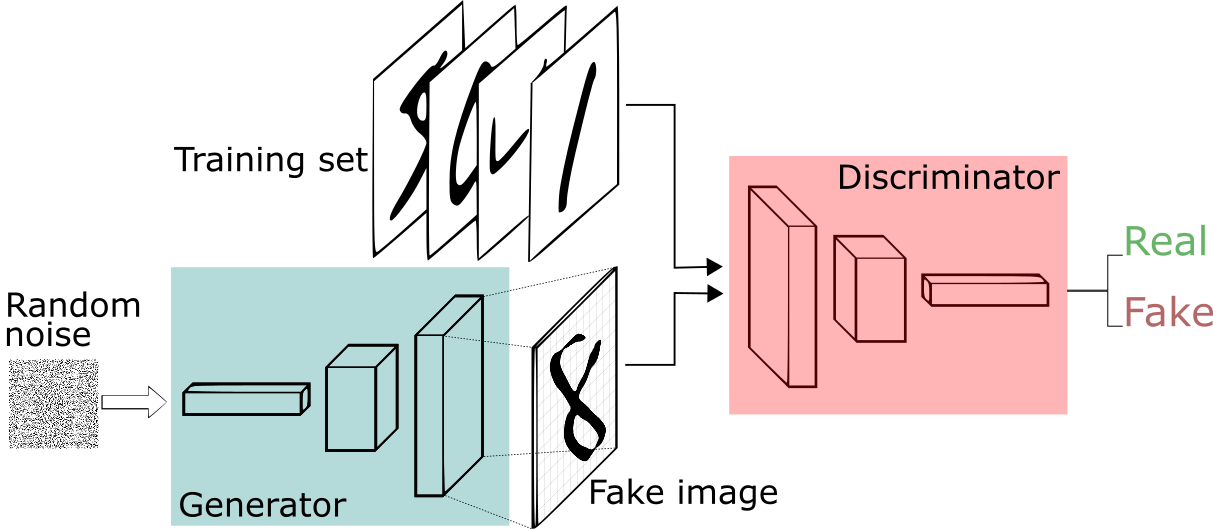

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
device='cuda' #image=image.to(device)

batch_size=128 #2**7 =>trainloader , training loop
noise_dim=64 #8*8 =>generator model

#optimizer parameters
lr=0.0002
beta_l=0.5
beta_2=0.99

#Training veriables
epochs=20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs=T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor() #(h,w,c)->(c,h,w)
])

In [5]:
trainset=datasets.MNIST('MNIST/',download=True,train=True,transform=train_augs)

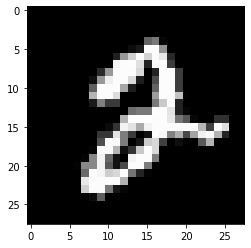

In [6]:
image,label=trainset[5]
plt.imshow(image.squeeze(),cmap='gray')

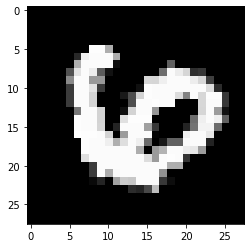

In [7]:
ima,label=trainset[9000]
plt.imshow(ima.squeeze(),cmap='gray')

In [8]:
print("total imaged present in train set are :" , len(trainset))

total imaged present in train set are : 60000


# Load Dataset Into Batches 

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader=DataLoader(trainset,batch_size =batch_size,shuffle=True)

In [11]:
print("total number of batches in trainloader :",len(trainloader))

total number of batches in trainloader : 469


In [12]:
dataiter=iter(trainloader)
images,_=dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [13]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

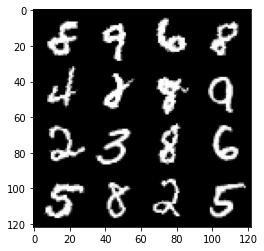

In [14]:
show_tensor_images(images,num_images=16)

# Create Discriminator Network 

In [15]:
#In case if torch summary is not installed 
#discriminal network is a simple binary classifier which classifies whether and given image is a real image or a fake image 

!pip install torchsummary

In [16]:
from torch import nn
from torchsummary import summary

In [17]:
'''

Network : Discriminator

input : (bs, 1, 28, 28) bs=batch_size 
input(batch_size,number_of_channel,hieght,width)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28) bs=batch_size \ninput(batch_size,number_of_channel,hieght,width)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n    

In [18]:
def get_disc_block(in_channels,out_channels,kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2) #activation function
  )

In [19]:
from torch.nn.modules.flatten import Flatten

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block_1=get_disc_block(1,16,(3,3),2)
    self.block_2=get_disc_block(16,32,(5,5),2)
    self.block_3=get_disc_block(32,64,(5,5),2)
    
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64,out_features=1)
  
  def forward(self,images):
    x1=self.block_1(images)
    x2=self.block_2(x1)
    x3=self.block_3(x2)

    x4=self.flatten(x3)
    x5=self.linear(x4)

    return x5

In [20]:
D=Discriminator()
D.to(device)
summary(D,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [21]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim) =(batch_size,noise_dimension)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) =(bs,64,1,1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim) =(batch_size,noise_dimension)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) =(bs,64,1,1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                     

In [22]:
def get_gen_block(in_channels,out_channels,kernel_size,stride ,final_block=False):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )


In [30]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super(Generator,self).__init__()

    self.noise_dim=noise_dim
    self.block_1=get_disc_block(noise_dim,256,(3,3),2)
    self.block_2=get_disc_block(256,128,(4,4),1)
    self.block_3=get_gen_block(128,64,(3,3),2)

    self.block_4=get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):
    #(bs,noise_dim) -> (bs,noise_dim,1,1)

    x=r_noise_vec.view(-1,self.noise_dim,1,1)

    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)
    return x4


In [31]:
G=Generator(noise_dim)
G.to(device)



Generator(
  (block_1): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [32]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [33]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [34]:
from logging import critical
def real_loss(disc_pred):
  criterion=nn.BCEWithLogistisLoss()
  ground_truth=torch.ones_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss
def fake_loss(disc_pred):
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

In [35]:
D_opt=torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_l,beta_2))
G_opt=torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_l,beta_2))

# Training Loop 

In [37]:
for i in range(epochs):
  total_d_loss=0.0
  total_g_loss=0.0
  for real_img, _ in tqdm(trainloader):
    real_img=real_img.to(device)
    noise=torch.randn(batch_size,noise_dim,device=device)

    #find loss and update weights for D
    D_opt.zero_grad()

    fake_img=G(noise)
    D_pred=D(fake_img)
    D_fake_loss=fake_loss(D_pred)

    D_pred=D(real_img)
    D_real_loss=real_loss(D_pred)

    D_loss=(D_fake_loss + D_real_loss)/2

    total_d_loss+=D_loss.item()

    D_loss.backward()
    D_opt.step()


    #find loss and update weights for G 
    G_opt.zero_grad()
    noise_img=torch(batch_size,noise_dim,device=device)

    fake_img=G(noise)
    D_pred=D(fake_img)
    G_loss=real_loss(D_pred)

    total_g_loss +=G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss=total_d_loss/len(trainloader)
  avg_g_loss=total_g_loss/len(trainloader)

  print("epoch :  | D_loss : {}".format(i+1,avg_d_loss,avg_g_loss))
  show_tensor_images(fake_img)




  0%|          | 0/469 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)